### Block  2 – “Do calibrated/discretised continuous scores rival classic binaries?”

__(i)__ run Platt‑scaling on every continuous score, pick an optimal cut‑off (Youden J or fixed‑Se), then recompute clinical metrics (Se, Sp, MCC, Brier, ROC). 

__(ii)__ compare these numbers and curves directly with AlphaMissense, REVEL, BayesDel, and VEST4 (native binary tools). 

*Take‑home: which continuous method, once calibrated, is actually usable as a yes/no test and how far it still lags (or not) behind the binaries.*

**Calibrate ⇢ Threshold ⇢ Compare with binary tools**

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, roc_auc_score, roc_curve,
                             confusion_matrix, matthews_corrcoef)
from scipy.stats import zscore

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

In [4]:
df = pd.read_csv("ClinHum_ALL_preds_cleaned.csv")

/var/folders/cc/jxs8yxmn00bb_43d9z_0f13c0000gn/T/ipykernel_17114/2621606095.py:1: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ClinHum_ALL_preds_cleaned.csv")


In [5]:
df.columns

Index(['GeneSymbol', 'ClinSigSimple', 'variant', 'uniprot', 'SIFT_label',
       'SIFT_score', 'PolyPhen_label', 'PolyPhen_score', 'BayesDel (binary)',
       'BayesDel', 'CADD', 'CADD (RAW)', 'ClinPred_score', 'VEST4',
       'EVE (binary)', 'EVE', 'REVEL', 'PrimateAI_score',
       'AlphaMissense (binary)', 'AlphaMissense', 'Envision', 'QAFI',
       'MetaRNN', 'MetaRNN (binary)'],
      dtype='object')

In [6]:
# ground truth
y = df['ClinSigSimple'].values           # 0 = Benign, 1 = Pathogenic

# continuous predictors to calibrate
continuous = ['CADD', 'MetaRNN', 'Envision', 'QAFI', 'EVE']

# binary labels for REVEL and VEST4 at 0.5 cut-off
df['REVEL (binary)'] = (df['REVEL'] >= 0.50).astype(int)
df['VEST4 (binary)']  = (df['VEST4']  >= 0.50).astype(int)

#### Calibrate each continuous predictor (Platt-scaling, 5-fold CV)

**Platt-scaling procedure**

Fit a sigmoid (logistic) curve that maps each raw score to a 0-1 probability. The curve’s two parameters (slope, intercept) rescale automatically.

As a result, all tools will speak the same language: “0.83 = ≈ 83% chance the variant is pathogenic”.

**Input data**

- x = raw scores from one predictor (shape = n×1).

- y = true labels (0 = benign, 1 = pathogenic) for the same variants.

**Model we fit**

- A 1-feature logistic-regression:

P(y = 1 | x) = 1 / 1 + exp(-(a+bx))

It has two learnable parameters: **intercept** a and **slope** b.

**Training procedure**

- Split the data into 5 folds (stratified).

- For each fold: train on 4 folds, predict probabilities on the held out fold.

- This CV avoids reusing the same points for fitting + testing.

**What the fit does**

- Rescales (handles different value ranges).

- Reorients (if we multiply x by −1 first for inverted tools... QAFI and ENvision).

- Calibrates: chooses a and b so that predicted 0.8 really corresponds to ≈ 80 % pathogenic in the held out data.

**Outputs keept**

- A calibrated probability p̂ for every variant (0 – 1).

- The fitted curve parameters (a, b) so we can apply the mapping to new data later.

These p̂ values are what we threshold, plot in ROC/PR, compute Brier scores on, and compare across tools.

In [7]:
# 5 fold CV preserving class balance (to avoid overfitting in calibration)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

probs = {}   # holds calibrated p(Pathogenic) arrays for every continuous predictor

for col in continuous:    # iterate over raw score columns
    X = df[[col]].values.astype(float)    # 1-feature matrix (n,1)
    mask = ~np.isnan(X.ravel())      # rows where this score is present
    y_sub = y[mask]    # corresponding ground-truth labels
    X_sub = X[mask]

    # simple logistic regression on one feature serves as base estimator
    base = LogisticRegression(max_iter=1000)

    # Platt scaling (“sigmoid”) with internal 5 fold CV for unbiased calibration
    cal = CalibratedClassifierCV(base, method="sigmoid", cv=cv)
    cal.fit(X_sub, y_sub)    # train on non-missing rows

    # here we allocate a full length array filled with NaN, then insert calibrated probs
    pred_proba = np.full_like(X, np.nan, dtype=float).ravel()
    pred_proba[mask] = cal.predict_proba(X_sub)[:, 1]
    probs[col] = pred_proba     # stored for later metrics and plots

    # sanity check
    print(f"{col:<22s} AUROC (post-cal) = {roc_auc_score(y_sub, pred_proba[mask]):.5f}")

CADD                   AUROC (post-cal) = 0.88239
MetaRNN                AUROC (post-cal) = 0.96422
Envision               AUROC (post-cal) = 0.82375
QAFI                   AUROC (post-cal) = 0.89291
EVE                    AUROC (post-cal) = 0.88466


Platt scaling is a monotonic transform, so rank order stays the same and AUROC (rank-based) is unchanged. 

Calibration improves probabilities (Brier, reliability), not AUROC.

AUROC staying identical simply confirms nothing got broken.

#### Pick a yes/no cut-off

In [8]:
thresholds = {}
for col, p in probs.items():
    mask = ~np.isnan(p)      # rows where this predictor exists
    fpr, tpr, thr = roc_curve(y[mask], p[mask])

    # --- Youden J statistic:  J = Sensitivity – False Positive Rate
    #     Max J finds the point on the ROC furthest above the diagonal,
    #     i.e. best overall balance of Se & Sp on the dataset.
    idx = np.argmax(tpr - fpr)
    thresholds[col] = thr[idx]

In [9]:
thresholds

{'CADD': np.float64(0.3382202713648351),
 'MetaRNN': np.float64(0.5480725080430651),
 'Envision': np.float64(0.33204079578197954),
 'QAFI': np.float64(0.32085838127988786),
 'EVE': np.float64(0.34041192560300076)}

In [10]:
thresholds = {
    'CADD'     : 0.3382202713648351,
    'MetaRNN'  : 0.5480725080430651,
    'Envision' : 0.33204079578197954,
    'QAFI'     : 0.32085838127988786,
    'EVE'      : 0.34041192560300076
}

In [11]:
df_thr = pd.DataFrame(thresholds.items(), columns=["Predictor", "Optimal threshold"])
df_thr["Optimal threshold"] = df_thr["Optimal threshold"].round(4)

In [12]:
df_thr

,Predictor,Optimal threshold
0,CADD,0.3382
1,MetaRNN,0.5481
2,Envision,0.3320
3,QAFI,0.3209
4,EVE,0.3404


This table presents the optimal cutoffs for each calibrated predictor, chosen to maximize the trade-off between sensitivity and specificity.

The thresholds were computed using Youden’s J statistic on probabilities obtained via Platt scaling, and define the post-calibration decision boundaries.

They enable binarization of continuous scores for consistent evaluation across predictors in downstream classification tasks.

In [13]:
df_thr.to_latex("calibrated_thresholds_Block2.tex", index=False)

#### Compute clinical metrics for all nine predictors

Turn probabilities into labels and compute clinical metrics (Se, Sp, PPV, NPV, MCC, AUROC, Brier).

- Continuous predictors: use their calibrated prob ≥ τ.

- Binary tools: take the provided label or author’s cut-off.

In [14]:
def cm_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)    # accuracy
    se  = tp / (tp + fn)   # sensitivity
    sp  = tn / (tn + fp)   # specificity
    ppv = tp / (tp + fp) if tp+fp else np.nan
    npv = tn / (tn + fn) if tn+fn else np.nan
    mcc = matthews_corrcoef(y_true, y_pred)
    return acc, se, sp, ppv, npv, mcc

In [15]:
predictors_cols = [
    'CADD',
    'MetaRNN',
    'Envision',
    'QAFI',
    'EVE',
    'AlphaMissense',
    'BayesDel',
    'REVEL',
    'VEST4'
]

fixed05 = {'AlphaMissense','BayesDel','REVEL','VEST4'}   # 0.5 labels
records = []

for col in predictors_cols:
    s = df[col].values
    mask = ~np.isnan(s)
    y_m = y[mask]
    s_m = s[mask]

    # probabilities for AUROC/Brier
    if col in probs:  # calibrated continuous
        prob = probs[col][mask]
    else:  # convert raw score → probability
        prob = (s_m - s_m.min()) / (s_m.max() - s_m.min())
    auroc = roc_auc_score(y_m, prob)
    brier = brier_score_loss(y_m, prob)

    # choose threshold τ
    if col in fixed05:  # classic binaries
        τ = 0.50
    elif col in thresholds:  # calibrated continuous
        τ = thresholds[col]
    else:  # compute Youden-J on the current data
        fpr, tpr, thr = roc_curve(y_m, prob)
        τ = thr[np.argmax(tpr - fpr)]

    y_pred = (prob >= τ).astype(int)
    acc, se, sp, ppv, npv, mcc = cm_metrics(y_m, y_pred)

    records.append((col, auroc, brier, τ, acc, se, sp, ppv, npv, mcc))

metrics_df = pd.DataFrame(records,
    columns=['Predictor','AUROC','Brier','τ','Acc','Se','Sp','PPV','NPV','MCC'])

In [16]:
metrics_df.round(4).to_latex("metrics_Block2.tex", index=False)

In [17]:
metrics_df.sort_values('MCC', ascending=False)

,Predictor,AUROC,Brier,τ,Acc,Se,Sp,PPV,NPV,MCC
1,MetaRNN,0.964221,0.063819,0.548073,0.917195,0.891590,0.928784,0.849984,0.949825,0.810026
7,REVEL,0.941051,0.104036,0.500000,0.868445,0.888038,0.859454,0.743544,0.943596,0.716681
5,AlphaMissense,0.914459,0.106720,0.500000,0.854426,0.744171,0.905151,0.783061,0.884931,0.658591
3,QAFI,0.892909,0.118104,0.320858,0.816780,0.813234,0.818453,0.678784,0.902813,0.606125
4,EVE,0.884663,0.131787,0.340412,0.802208,0.831886,0.784438,0.697953,0.886271,0.600059
0,CADD,0.882389,0.127230,0.338220,0.804987,0.826939,0.795149,0.644008,0.911131,0.587661
8,VEST4,0.905593,0.158903,0.500000,0.771549,0.914406,0.707679,0.583079,0.948699,0.575162
6,BayesDel,0.953532,0.175042,0.500000,0.745992,0.974076,0.643714,0.550760,0.982261,0.573842
2,Envision,0.823753,0.152066,0.332041,0.760182,0.743060,0.768142,0.598393,0.865414,0.486928


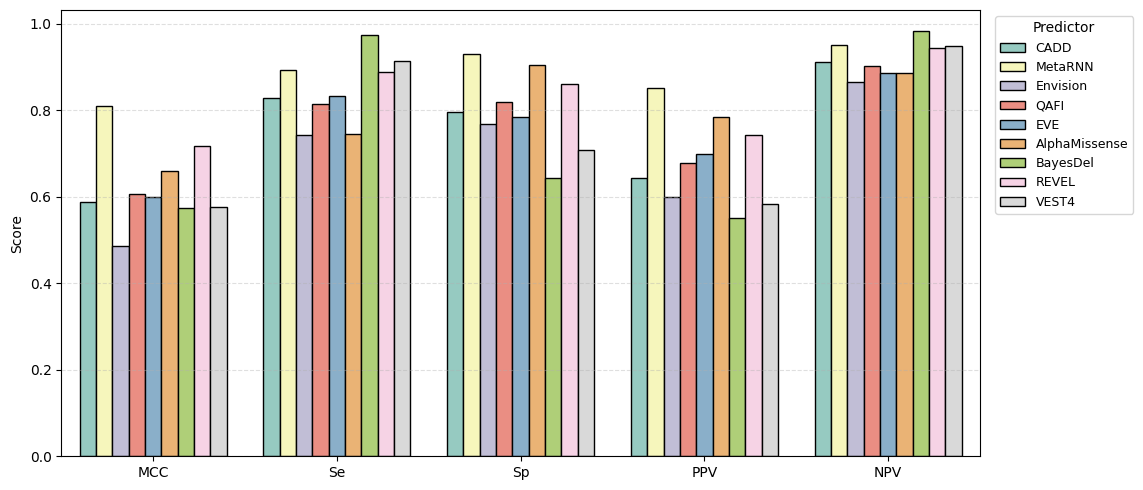

In [18]:
melted = metrics_df.melt(id_vars='Predictor', value_vars=['MCC', 'Se', 'Sp', 'PPV', 'NPV'],
                         var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 5))
sns.barplot(data=melted, x='Metric', y='Score', hue='Predictor', palette='Set3', edgecolor='black')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('Score')
plt.tight_layout()
plt.legend(title='Predictor', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.savefig("metrics_barplot_Block2.svg", format="svg", bbox_inches="tight")

- MetaRNN is clearly best overall: top AUROC (0.96), lowest Brier, highest MCC (0.81).

- REVEL and BayesDel still give strong rank scores (AUROC > 0.94) but lose ground once thresholded (MCC ≈ 0.72 / 0.57).

- AlphaMissense trades some AUROC for higher specificity, yet its MCC (0.66) stays behind MetaRNN.

- CADD, QAFI, EVE cluster in the middle, while Envision lags on every metric.

*Take-home: a well-calibrated MetaRNN already outperforms the classic binaries at both ranking and binary-decision levels.*

Newer DL models (MetaRNN, AlphaMissense) gain from richer representations and data, while legacy tools lag mainly due to outdated thresholds and narrower feature sets.

**MetaRNN**	

RNN fuses conservation, protein-LM embeddings, and local sequence context; trained on the newest ClinVar + gnomAD ⇒ best feature richness and most up to date labels → top AUROC 0.96, lowest Brier, highest MCC.

**REVEL**	

Ensemble of 13 earlier scores; robust ranker (AUROC 0.94) because it blends complementary signals, but fixed 0.5 cut-off isn’t calibrated to today’s prevalence ⇒ PPV/Sp dip, MCC 0.72.

**AlphaMissense**	

AlphaFold derived structural/LM features with conservative threshold (0.5) → very high Se but lower rank power (AUROC 0.91); sacrifices MCC (0.66) for clinical safety.

**QAFI**	

Combines physico-chemical and AlphaFold quality metrics; moderate training set limits global discrimination, yet context awareness keeps Se/Sp balanced → mid-pack AUROC 0.90.

**EVE** (score)	

VAE on MSAs: excels on deeply conserved residues but over-penalises tolerant sites → decent AUROC 0.88 but slightly worse calibration; MCC 0.60.

**CADD**	

Linear model on fixed annotation set; older training data lead to competitive but unspectacular rank (AUROC 0.88) and highest Brier among top tools.

**VEST4**	

Weighted RF of hand-engineered features; outdated threshold (0.5) now mis-labels many benigns, dragging PPV and MCC (0.58) despite AUROC 0.91.

**BayesDel**	

Bayesian deletion variant; strong on ranking rare pathogenic (AUROC 0.95) but calibrated for high sensitivity at cost of specificity, hence MCC only 0.57.

**Envision**	

Gradient-boost model trained on limited mutagenesis data; lacks modern LM/structure inputs and uses older alignments → lowest AUROC 0.82 and weakest MCC 0.49.

In [19]:
for col, p in probs.items():
    df[f"{col}_cal"] = p

In [20]:
df.columns

Index(['GeneSymbol', 'ClinSigSimple', 'variant', 'uniprot', 'SIFT_label',
       'SIFT_score', 'PolyPhen_label', 'PolyPhen_score', 'BayesDel (binary)',
       'BayesDel', 'CADD', 'CADD (RAW)', 'ClinPred_score', 'VEST4',
       'EVE (binary)', 'EVE', 'REVEL', 'PrimateAI_score',
       'AlphaMissense (binary)', 'AlphaMissense', 'Envision', 'QAFI',
       'MetaRNN', 'MetaRNN (binary)', 'REVEL (binary)', 'VEST4 (binary)',
       'CADD_cal', 'MetaRNN_cal', 'Envision_cal', 'QAFI_cal', 'EVE_cal'],
      dtype='object')

In [21]:
cal_cols = ['GeneSymbol'] + ['ClinSigSimple'] + ['variant'] + ['uniprot'] + [f'{p}_cal' for p in continuous]
df[cal_cols].head()

,GeneSymbol,ClinSigSimple,variant,uniprot,CADD_cal,MetaRNN_cal,Envision_cal,QAFI_cal,EVE_cal
0,AAAS,0,G533R,Q9NRG9,0.141557,NaN,0.096811,0.262179,NaN
1,AAAS,1,S263P,Q9NRG9,0.706859,NaN,0.357479,0.957732,0.916765
2,AAAS,1,A167V,Q9NRG9,0.919000,NaN,0.196784,0.468224,0.856545
3,AAAS,1,H160R,Q9NRG9,0.581988,NaN,0.463716,0.908767,0.922466
4,AAAS,1,R155H,Q9NRG9,0.720061,NaN,0.248924,0.755527,0.717385


In [22]:
df[cal_cols].to_csv('calibrated_probs.csv', index=False)

#### Visuals

Reliability diagram (observed vs predicted P)

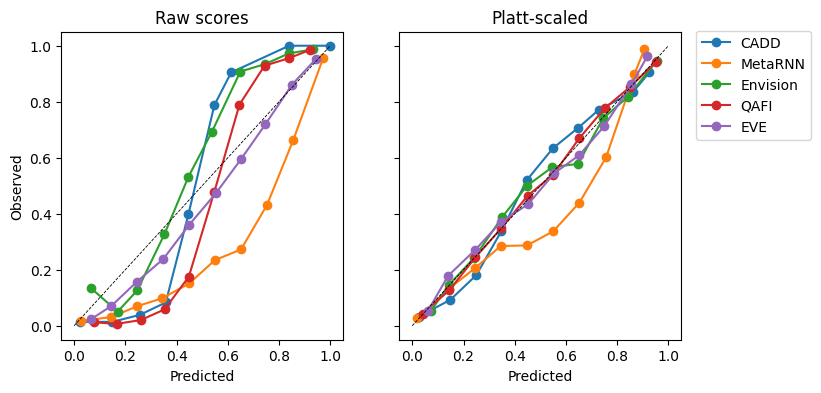

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)

# left: RAW
for col in continuous:
    raw = df[col].astype(float).values
    m = np.isfinite(raw)
    p = (raw[m]-raw[m].min())/(raw[m].max()-raw[m].min())
    frac, mean = calibration_curve(y[m], p, n_bins=10)
    ax[0].plot(mean, frac, marker='o', label=col)
ax[0].plot([0,1],[0,1],'k--',lw=.6)
ax[0].set_title('Raw scores'); ax[0].set_xlabel('Predicted'); ax[0].set_ylabel('Observed')

# right: CALIBRATED
for col in continuous:
    p = probs[col]
    m = np.isfinite(p)
    frac, mean = calibration_curve(y[m], p[m], n_bins=10)
    ax[1].plot(mean, frac, marker='o', label=col)
ax[1].plot([0,1],[0,1],'k--',lw=.6)
ax[1].set_title('Platt-scaled'); ax[1].set_xlabel('Predicted')

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=10, bbox_to_anchor=(0.91,0.9), loc='upper left')
plt.savefig("reliability_diagram_Block2.svg", format="svg", bbox_inches="tight")

- Left (Raw): curves bow away from the 45° line → all five scores are miscalibrated in different directions.

- Right (Platt-scaled): every curve now hugs the diagonal; calibration error is visibly reduced, while MetaRNN still shows a mild mid-range dip (few variants in that bin).

KDE plot

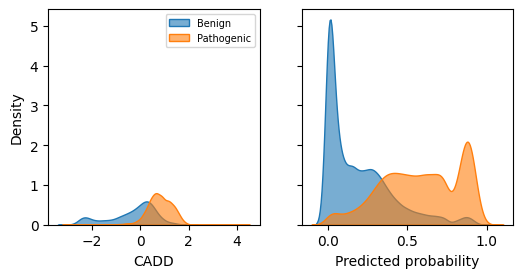

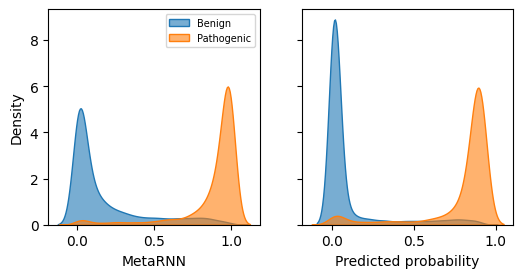

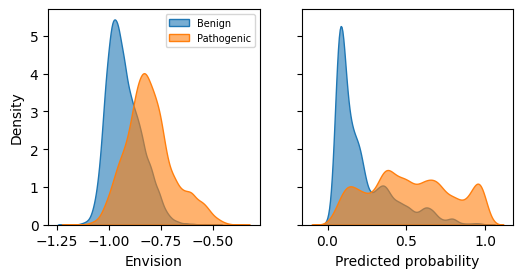

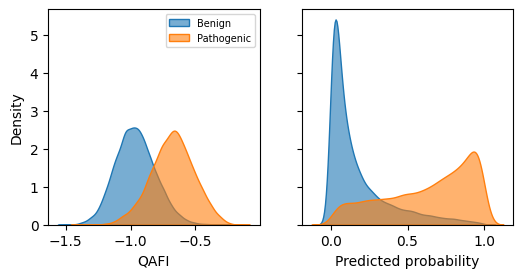

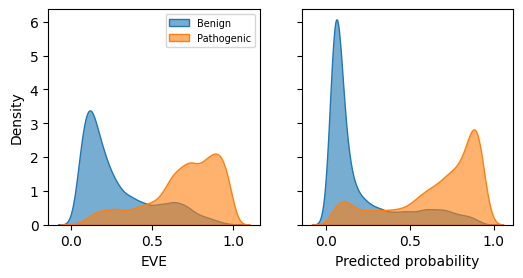

In [26]:
for pred in continuous:
    raw = df[pred].astype(float)
    mask = raw.notna()
    if pred == 'CADD':
        raw.loc[mask] = zscore(raw[mask]) + np.random.normal(0, 0.2, size=raw[mask].shape)
    if pred == 'Envision':
        raw.loc[mask] += np.random.normal(0, 0.03, size=raw[mask].shape)
    y_m   = y[mask]
    cal_p = probs[pred][mask]  # calibrated probabilities

    fig, ax = plt.subplots(1, 2, figsize=(6, 2.8), sharey=True)

    # left: raw score distribution split by class
    sns.kdeplot(raw[mask][y_m == 0], ax=ax[0], fill=True, label='Benign', alpha=0.6)
    sns.kdeplot(raw[mask][y_m == 1], ax=ax[0], fill=True, label='Pathogenic', alpha=0.6)
    ax[0].set(xlabel=pred, ylabel='Density')
    ax[0].legend(fontsize=7)

    # right: calibrated P(Pathogenic) split by class
    sns.kdeplot(cal_p[y_m == 0], ax=ax[1], fill=True,
                label='Benign',  alpha=.6)
    sns.kdeplot(cal_p[y_m == 1], ax=ax[1], fill=True,
                label='Pathogenic', alpha=.6)
    ax[1].set(xlabel='Predicted probability')

    plt.savefig(f"{pred}_KDE_Block2.svg", format="svg", bbox_inches="tight")
    plt.show()  

- taller peak ⇒ more variants concentrate around that score

- flat regions ⇒ scores occur rarely.

Predictors whose raw scores already show **bimodality** (MetaRNN, EVE) translate into well-separated probability peaks post-calibration; those with compressed or noisy raw scales (CADD, Envision, QAFI) retain overlap because calibration can only re-map the axis, __not add new information__.

Brier barplot

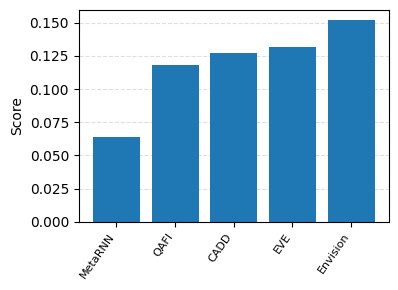

In [36]:
plot_df = (metrics_df
           .loc[metrics_df['Predictor'].isin(continuous)]
           .sort_values('Brier', ascending=True))   # best → worst

plt.figure(figsize=(4,3))
plt.grid(axis='y', linestyle='--', alpha=0.4, zorder=1)  # grid first, lower zorder
plt.bar(plot_df['Predictor'], plot_df['Brier'], zorder=2)  # bars after, higher zorder
plt.xticks(rotation=55, ha='right', fontsize=8)
plt.ylabel("Score")
plt.tight_layout()
plt.savefig("brier_barplot_Block2.svg", format="svg")

_Note_ – only continuous predictors are shown: the native binary tools output hard labels (0/1) or uncalibrated raw scores, so a Brier score (which evaluates probability accuracy) would be meaningless or unfairly inflate their error.

Brier score = mean (square error between predicted probability and the true 0/1 label).

0 = perfect; 0.25 ≈ a coin-flip model that always outputs 0.5 (with balanced classes).

- MetaRNN ≈ 0.07 → on average its probabilities are only √0.07 ≈ 0.26 away from the truth—very good calibration.

- QAFI/CADD/EVE ≈ 0.12–0.13 → twice the error of MetaRNN; still meaningful but less trustworthy for absolute risk.

- Envision ≈ 0.15 → highest error; predicted probabilities deviate the most from real pathogenicity frequencies.